# Policing and racism protests in the US during 2020 

### Summary/Background
On May 25th, George Floyd was murdered by police officer Derek Chauvin while he was being accused of trying to pass a counterfeit twenty dollar bill. The video of the incident went viral and this killing sparked massive protests across the country. In the two weeks following George Floyd’s death, polls reported that between 15 and 26 million people participated in protests related to police misconduct (link). 

Given that background, we explored the circumstances surrounding the protests in the year of 2020. We looked at the frequency of protests over the year, and found a spike and lasting effect after May 2020.

### Exploratory Questions
We seek to answer the following questions by joining and analyzing the datasets listed above. The following four question categories have guided this report. 
* How were protests distributed across the United States? 
    * In size 
    * In frequency (number of protests per day)
    * Geographically 
* Is there a difference in the geographic distribution of protests of opposite political valence? 
* Which organizations were involved in most protests? 
* Is there an association between:
    * The frequency of protests and unemployment rates? 
    * The size of protests and unemployment rates? 
    * The frequency of protests and population? 
    * The size of protests and population? 


## Environment Set Up 

In [12]:
### IMPORT REQUIRED LIBRARIES ###

import re 
from datetime import datetime 
import calendar

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd

# Set option for pd dataframes to show all columns when called 
pd.set_option("display.max_columns", None)

## Load and observe data

In [13]:
# Read data 
protests_df = pd.read_csv("data/ccc_compiled.csv") 
protests_df.shape

/Users/aymanbari/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,8,9,11,12,23,25,27,30,31,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(84662, 67)

In [14]:
list(protests_df.columns)

['date',
 'locality',
 'state',
 'location',
 'location_detail',
 'county',
 'online',
 'type',
 'title',
 'macroevent',
 'actors',
 'organizations',
 'participants',
 'claims',
 'valence',
 'issues',
 'size_text',
 'size_low',
 'size_high',
 'size_mean',
 'size_cat',
 'arrests',
 'arrests_any',
 'injuries_crowd',
 'injuries_crowd_any',
 'injuries_police',
 'injuries_police_any',
 'property_damage',
 'property_damage_any',
 'chemical_agents',
 'participant_measures',
 'police_measures',
 'participant_deaths',
 'police_deaths',
 'source_1',
 'source_2',
 'source_3',
 'source_4',
 'source_5',
 'source_6',
 'source_7',
 'source_8',
 'source_9',
 'source_10',
 'source_11',
 'source_12',
 'source_13',
 'source_14',
 'source_15',
 'source_16',
 'source_17',
 'source_18',
 'source_19',
 'source_20',
 'source_21',
 'source_22',
 'source_23',
 'source_24',
 'source_25',
 'source_26',
 'notes',
 'lat',
 'lon',
 'resolved_locality',
 'resolved_county',
 'resolved_state',
 'fips_code']

### Pre-process protest data

In [15]:
# Mutate column types to requrement 
protests_df["date"] = pd.to_datetime(protests_df["date"])
protests_df["month_year"] = pd.to_datetime(protests_df['date']).dt.to_period('M').dt.to_timestamp()
protests_df["month_year"] = pd.to_datetime(protests_df["month_year"])

# Removing data collected before 2020 
protests_df_filtered = protests_df[protests_df["date"] > datetime(2020, 1, 1)]
protests_df_filtered = protests_df_filtered[protests_df_filtered["date"] < datetime(2021, 1, 1)]

# Filter for non-online issues only 
protests_df_filtered = protests_df_filtered[protests_df_filtered["online"] != 1]

# Filter for issues where the issues included "policing" or "racism"
protests_df_filtered = protests_df_filtered[protests_df_filtered["issues"].str.contains("policing|racism", case=True, na=False)]

# Filter where size_cat > 1; size_cat key: 0 = unknown; 1 = 1-99; 2 = 100-999; 3 = 1,000-9,999; 4 = 10,000+ 
protests_df_filtered = protests_df_filtered[protests_df_filtered["size_cat"] > 1]

# Drop unrequired data. Check protests_df object for full data 
protests_df_filtered = protests_df_filtered.drop(protests_df_filtered.iloc[:, 6:9], axis = 1)
protests_df_filtered = protests_df_filtered.drop(['size_text'], axis = 1)
protests_df_filtered = protests_df_filtered.drop(protests_df_filtered.iloc[:, 17:57], axis = 1)

# Update the "resolved_county" column to match the format of the "county" column - remove characters "county "
protests_df_filtered["resolved_county"] = pd.Series(protests_df_filtered["resolved_county"]).str.replace(' County', '', regex=True)

# Remove data with missing fips codes (5 records at this point)
protests_df_filtered = protests_df_filtered.dropna(subset=["fips_code"], axis = 0)

In [16]:
protests_df.head()

,date,locality,state,location,location_detail,county,online,type,title,macroevent,actors,organizations,participants,claims,valence,issues,size_text,size_low,size_high,size_mean,size_cat,arrests,arrests_any,injuries_crowd,injuries_crowd_any,injuries_police,injuries_police_any,property_damage,property_damage_any,chemical_agents,participant_measures,police_measures,participant_deaths,police_deaths,source_1,source_2,source_3,source_4,source_5,source_6,source_7,source_8,source_9,source_10,source_11,source_12,source_13,source_14,source_15,source_16,source_17,source_18,source_19,source_20,source_21,source_22,source_23,source_24,source_25,source_26,notes,lat,lon,resolved_locality,resolved_county,resolved_state,fips_code,month_year
0,2017-01-20,Seattle,WA,"Seattle, WA",University of Washington campus,NaN,0.0,protest; demonstration,NaN,NaN,general protestors,NaN,NaN,anti-Yiannopolous; anti-Breitbart; anti-Trump,1.0,executive,NaN,200.0,700.0,450.0,2,1,1,1,1,0,0,1.0,1,NaN,NaN,NaN,NaN,NaN,http://infoweb.newsbank.com.du.idm.oclc.org/re...,http://www.seattletimes.com/seattle-news/north...,http://www.seattletimes.com/seattle-news/educa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.606209,-122.332071,Seattle,King County,WA,53033.0,2017-01-01
1,2017-01-21,Adak,AK,"Adak, AK",NaN,NaN,0.0,march,NaN,20170121-womensmarch,NaN,NaN,NaN,women's rights are human rights,1.0,women's rights,NaN,10.0,10.0,10.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,adn.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.880000,-176.658056,Adak,Aleutians West,AK,2016.0,2017-01-01
2,2017-01-21,Anchorage,AK,"Anchorage, AK",NaN,NaN,0.0,march,NaN,20170121-womensmarch,NaN,NaN,NaN,women's rights are human rights,1.0,women's rights,NaN,2000.0,4000.0,3000.0,3,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,https://www.adn.com/alaska-news/2017/01/21/lar...,https://twitter.com/julia_omalley/status/82290...,http://www.ktuu.com/content/news/Thousands-of-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.218056,-149.900278,Anchorage,Anchorage,AK,2020.0,2017-01-01
3,2017-01-21,Bethel,AK,"Bethel, AK",NaN,NaN,0.0,march,NaN,20170121-womensmarch,NaN,NaN,NaN,women's rights are human rights,1.0,women's rights,NaN,40.0,100.0,70.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,https://www.adn.com/slideshow/visual/2017/01/2...,http://kyuk.org/post/slideshow-bethel-proteste...,https://jackpineradicals.com/boards/topic/wome...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.792222,-161.755833,Bethel,Bethel,AK,2050.0,2017-01-01
4,2017-01-21,Cordova,AK,"Cordova, AK",NaN,NaN,0.0,march,NaN,20170121-womensmarch,NaN,NaN,NaN,women's rights are human rights,1.0,women's rights,NaN,108.0,114.0,111.0,2,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,onsite eyewitness who did headcount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.542409,-145.752541,Cordova,Valdez-Cordova,AK,2261.0,2017-01-01


In [17]:
protests_df_filtered.head() 

,date,locality,state,location,location_detail,county,macroevent,actors,organizations,participants,claims,valence,issues,size_low,size_high,size_mean,size_cat,lat,lon,resolved_locality,resolved_county,resolved_state,fips_code,month_year
38014,2020-01-12,Mineola,NY,"Mineola, NY",Nassau County Legislature,Nassau,NaN,Island-Wide Task Force against Anti-Semitism a...,NaN,NaN,against antisemitism and hate,0.0,racism; religion,2000.0,2000.0,2000.0,3,40.749268,-73.640684,Mineola,Nassau,NY,36059.0,2020-01-01
38016,2020-01-12,New York,NY,"New York, NY",Queens,Queens,NaN,general protesters,NaN,NaN,against antisemitism and hate,0.0,racism; religion,200.0,200.0,200.0,2,40.712775,-74.005973,New York,NaN,NY,36081.0,2020-01-01
38017,2020-01-12,Charleston,SC,"Charleston, SC",Synagauge Emanu-El,Charleston,NaN,The Charleston Jewish Federation; the Jewish C...,NaN,NaN,against antisemitism and hate,0.0,racism; religion,400.0,400.0,400.0,2,32.776475,-79.931051,Charleston,Charleston,SC,45019.0,2020-01-01
38756,2020-02-07,Baltimore,MD,"Baltimore, MD",Roland Park,Baltimore,NaN,school and community groups,NaN,NaN,"against racism in Roland Park, Black Lives Mat...",1.0,policing; racism,100.0,150.0,125.0,2,39.290385,-76.612189,Baltimore,NaN,MD,24510.0,2020-02-01
38768,2020-02-08,Washington,DC,"Washington, DC",Arlington National Cemetery to U.S. Capitol,DC,NaN,Patriot Front,NaN,NaN,"for white supremacy, against Jews, against com...",2.0,democracy; racism,150.0,150.0,150.0,2,38.907192,-77.036871,Washington,District of Columbia,DC,11001.0,2020-02-01


### Preparing county population data for join. 

In [18]:
# Read data 
county_pop_df = pd.read_csv("data/population_by_county/DECENNIALPL2020.P1_data_with_overlays_2021-11-21T135424.csv", header = 1) 

# Remove unrequried fields - remove population by race. Keep total only. 
county_pop_df_filtered = county_pop_df.drop(county_pop_df.iloc[:,3:], axis = 1)

county_pop_df_filtered = county_pop_df_filtered.set_axis(['fips_code', 'county', 'population'], axis = 1)

# Mutate fips_code column for join with protests dataset 
county_pop_df_filtered["fips_code"] = county_pop_df_filtered["fips_code"].apply(lambda x: float(x[9:]))

county_pop_df_filtered

,fips_code,county,population
0,1.001000e+03,"Autauga County, Alabama",58805
1,1.003000e+03,"Baldwin County, Alabama",231767
2,1.005000e+03,"Barbour County, Alabama",25223
3,1.007000e+03,"Bibb County, Alabama",22293
4,1.009000e+03,"Blount County, Alabama",59134
...,...,...,...
3217,7.214700e+04,"Vieques Municipio, Puerto Rico",8249
3218,7.214900e+04,"Villalba Municipio, Puerto Rico",22093
3219,7.215100e+04,"Yabucoa Municipio, Puerto Rico",30426
3220,7.215300e+04,"Yauco Municipio, Puerto Rico",34172


### Preparing state population data for join.

In [19]:
# DATA FRAME FOR TOTAL STATE POPULATION 

# Source: https://data.ers.usda.gov/reports.aspx?ID=17827 

# Read data 
state_pop_df = pd.read_csv("data/StatePopulationReport.csv", header = 2)

# Frop columns that are not required 
state_pop_df = state_pop_df.drop(state_pop_df.iloc[:, 1:4], axis = 1)
state_pop_df = state_pop_df.drop(state_pop_df.iloc[:, 2:], axis = 1)

# Rename columns for join 
state_pop_df = state_pop_df.rename(columns={'Name': 'state_name', 'Pop. 2020': 'state_population'})
# Remove commas to convert to float 
state_pop_df["state_population"] = pd.Series(state_pop_df["state_population"]).str.replace(',', '', regex=True)
# Convert from string to float 
state_pop_df["state_population"] = pd.to_numeric(state_pop_df["state_population"], downcast ="float")

# Check df 
state_pop_df.head()

,state_name,state_population
0,United States,331449280.0
1,Alabama,5024279.0
2,Alaska,733391.0
3,Arizona,7151502.0
4,Arkansas,3011524.0


### Preparing geographic data for join
Note - This data is not available on the repo as the file was larger than 100MB. To run this notebook, please download the geographic data from the following link and adjust the path in the code block below. 

https://public.opendatasoft.com/explore/dataset/us-county-boundaries/export/?disjunctive.statefp&disjunctive.countyfp&disjunctive.name&disjunctive.namelsad&disjunctive.stusab&disjunctive.state_name&location=4,52.13349,-109.86328&basemap=jawg.light 

In [20]:
# COUNTY GEO SHAPE DATA 

# Load in data 
geo_df = gpd.read_file("data/us-county-boundaries/us-county-boundaries.shp")

# Add a column called fips code - state and county codes for joining with main dataset 
geo_df["fips_code"] = pd.to_numeric((geo_df["statefp"] + geo_df["countyfp"]), downcast='float')

#geo_df.head()

### Unemployment data for join

In [21]:
# LOAD IN UNEMPLOYMENT RATES PER STATE DATA 

# Load in and remove un-named index column 
unemployment_df = pd.read_csv("data/unemp2020.csv").iloc[:, 1:]
# unemployment_df = unemployment_df.drop(['state'], axis = 1)
unemployment_df = unemployment_df.rename(columns={'name': 'state_name'})

unemployment_df.head(10)

,state_name,state,rate
0,Alabama,AL,6.0
1,Alaska,AK,7.7
2,Arizona,AZ,7.7
3,Arkansas,AR,6.2
4,California,CA,10.2
5,Colorado,CO,7.3
6,Connecticut,CT,7.8
7,Delaware,DE,7.8
8,Florida,FL,7.9
9,Georgia,GA,6.6


### Join data for single master dataframe

In [22]:
# JOIN PROTESTS, COUNTY POPULATION AND GEO SHAPE DATA 

df = pd.merge(protests_df_filtered, county_pop_df_filtered, on='fips_code', how='left')

# Despite having the fips codes, the protests dataset is missing the origin county for some records. 
# Updating "county_y" from the census dataset to match the format of "county_resolved" for comparison 
df["county_y"] = df["county_y"].str.replace(' County([\s\S]*)$', '', regex=True)

# Add a column to account for the county population 
df["size_mean_over_pop"] = df["size_mean"]/df["population"]

# Merge with geo data 
df = pd.merge(df, geo_df, on='fips_code', how='left')

# Merge with geo data 
df = pd.merge(df, state_pop_df, on='state_name', how='left')

# Add a column to account for the state population 
df["size_mean_over_state_pop"] = df["size_mean"]/df["state_population"]

# Merge with unemployment rates data 
df = pd.merge(df, unemployment_df, on="state_name", how="left") 

df = df.rename(columns={'state_x':'state'})

# # Add a column to indicate if county and resolved_county are the same 
# df["single_county"] = (df["county_y"] == df["resolved_county"])

# # Check if merge worked as expected 
# print(len(df)) 
# print(len(protests_df_filtered))
# print(len(df) == len(protests_df_filtered))

## Data Exploration 

In [23]:
# Check dataframe structure 
# df.head() 
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4848 entries, 0 to 4847
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      4848 non-null   datetime64[ns]
 1   locality                  4848 non-null   object        
 2   state                     4847 non-null   object        
 3   location                  4848 non-null   object        
 4   location_detail           4493 non-null   object        
 5   county_x                  3252 non-null   object        
 6   macroevent                16 non-null     object        
 7   actors                    4845 non-null   object        
 8   organizations             0 non-null      object        
 9   participants              0 non-null      object        
 10  claims                    4848 non-null   object        
 11  valence                   4848 non-null   float64       
 12  issues              

## Which organizations were involved in most protests? 
Note - considering only protests with a single organing group

4845


<AxesSubplot:xlabel='actors'>

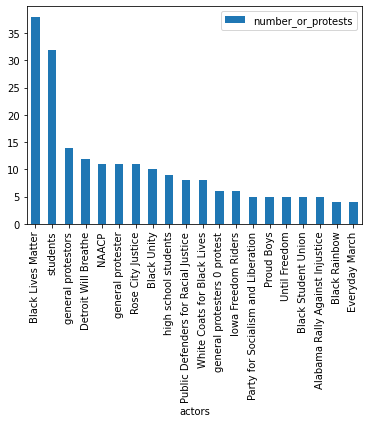

In [24]:
# CHECK THE ACTORS ORGANIZING THE PROTESTS 

actors_df = df[["date", "actors", "valence", "size_mean"]].dropna()
print(len(actors_df))


# Records where there are multiple actors 
multiple_actor_df = actors_df[actors_df["actors"].str.contains(";", case=True, na=False)]

# Records where there is only one actor 
single_actor_df = pd.concat([actors_df, multiple_actor_df]).drop_duplicates(keep=False)
single_actor_df = actors_df[actors_df["actors"].str.contains(";", case=True, na=False) == False]

# Group by the actors 
number_organized_per_actor = single_actor_df.groupby(["actors"]).size().reset_index(name="number_or_protests").sort_values(["number_or_protests"], ascending=False)
number_organized_per_actor.head()

# 687 groups that organized protests 
len(number_organized_per_actor)

number_organized_per_actor.iloc[1:21].plot(kind="bar", x="actors", y="number_or_protests")

# # Sanity check 
# print(len(multiple_actor_df)) 
# print(len(single_actor_df)) 

# print((len(multiple_actor_df)+len(single_actor_df)) == len(actors_df)) 

## Quick summary plots - size and frequency of protests over time, 2020

  month_year  n_protests
0 2020-01-01           3
1 2020-02-01          11
2 2020-03-01           4
3 2020-05-01         742
4 2020-06-01        2952


Text(0.5, 1.0, 'Total protests turnout per month')

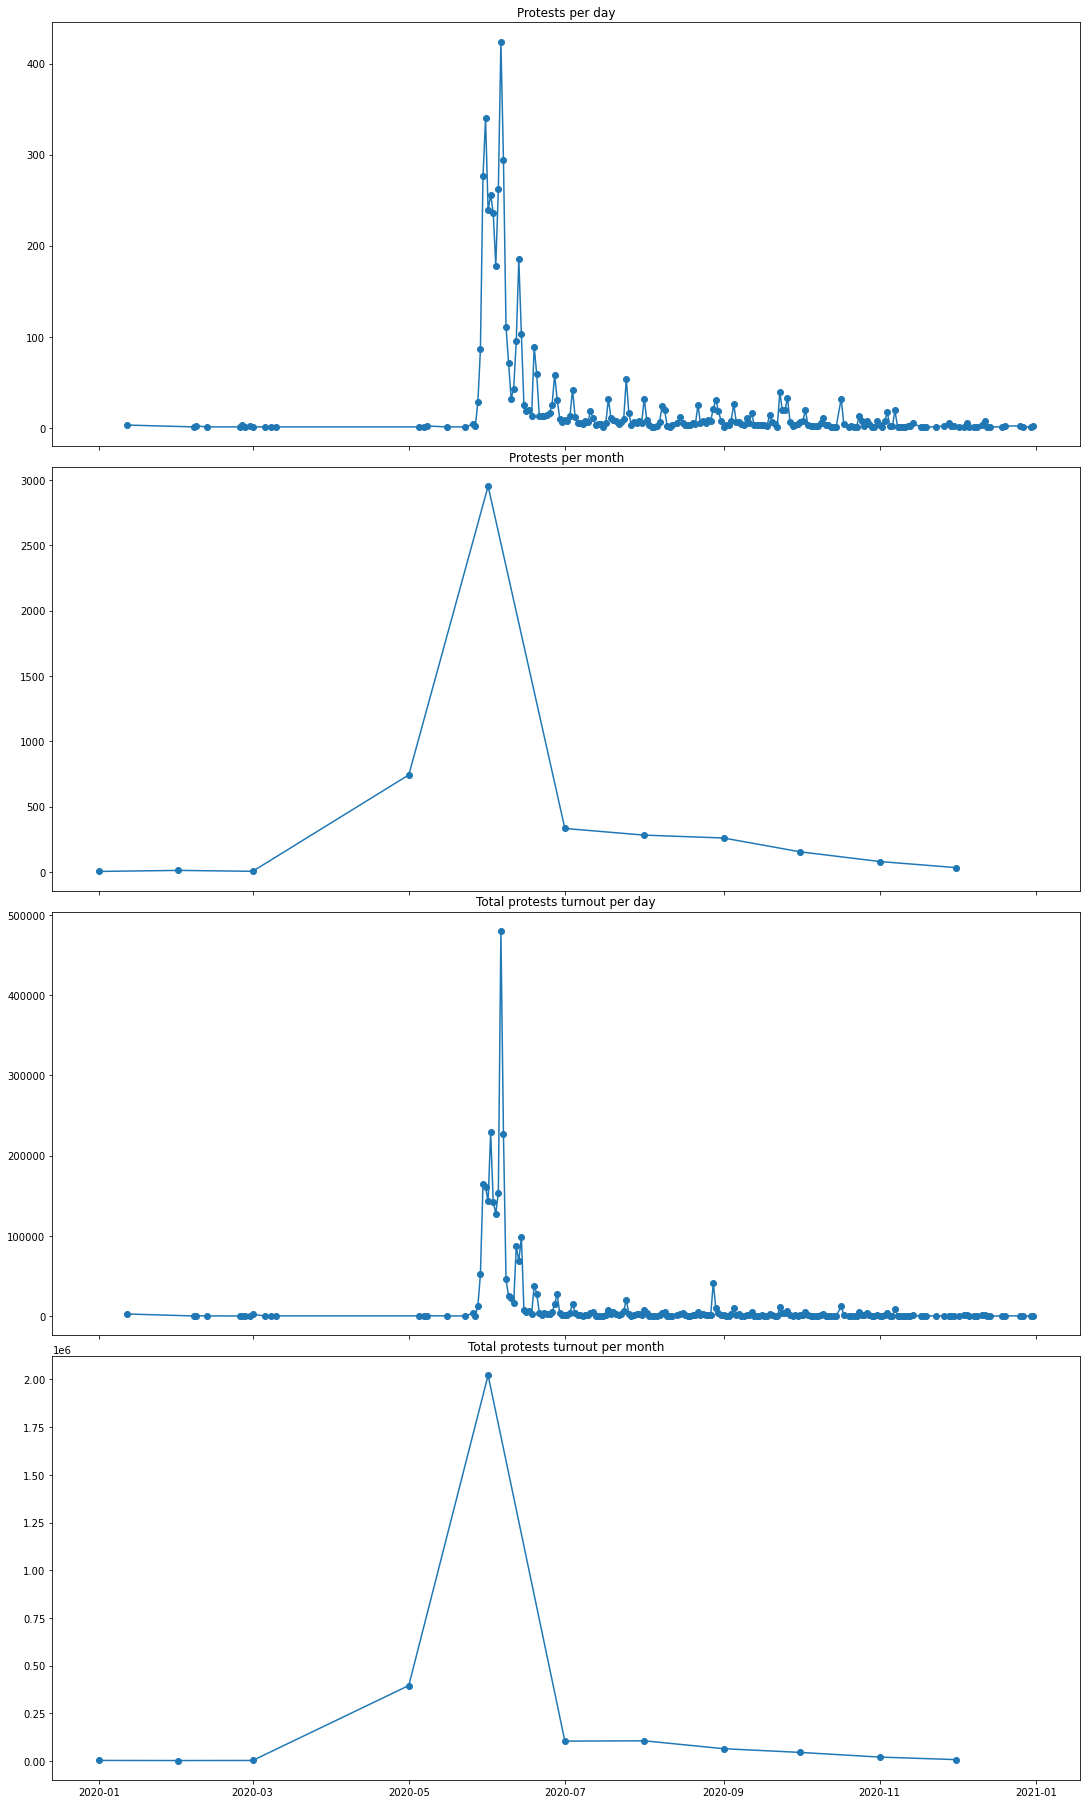

In [25]:
##### Plot number of protests over time - For FILTERED DATA SET 
# Summarize data to print the numebr of protests reported per day 
fig, ax = plt.subplots(4,1, sharex = True, figsize=(15,25))
fig.tight_layout()


# Summary tables for protests per-[time_frame] 
protests_per_day_filtered = df.groupby(["date"]).size().reset_index(name="n_protests")
protests_per_month_filtered = df.groupby(["month_year"]).size().reset_index(name="n_protests")
# print(protests_per_day_filtered.head())
print(protests_per_month_filtered.head())


# # Sum of size_mean per-[time-frame] 
protests_turnout_per_day_filtered = df.groupby(["date"]).sum("size_mean").reset_index()
protests_turnout_per_month_filtered = df.groupby(["month_year"]).sum("size_mean").reset_index()
# protests_turnout_per_day_filtered.head()
# protests_turnout_per_month_filtered.head()

# Total number of protests per day 
# ax[0].bar(data=protests_per_day_filtered, x="date", height="n_protests")
ax[0].plot(protests_per_day_filtered["date"], protests_per_day_filtered["n_protests"])
ax[0].scatter(data=protests_per_day_filtered, x="date", y="n_protests")
ax[0].set_title("Protests per day")

# Total number of protests per month 
# ax[1].bar(data=protests_per_month_filtered, x="month_year", height="n_protests")
ax[1].plot(protests_per_month_filtered["month_year"], protests_per_month_filtered["n_protests"])
ax[1].scatter(data=protests_per_month_filtered, x="month_year", y="n_protests")
ax[1].set_title("Protests per month")


# Total number of people that protest per day  
ax[2].plot(protests_turnout_per_day_filtered["date"], protests_turnout_per_day_filtered["size_mean"])
ax[2].scatter(data=protests_turnout_per_day_filtered, x="date", y="size_mean")
ax[2].set_title("Total protests turnout per day")

# Total number of people that protest per month  
ax[3].plot(protests_turnout_per_month_filtered["month_year"], protests_turnout_per_month_filtered["size_mean"])
ax[3].scatter(data=protests_turnout_per_month_filtered, x="month_year", y="size_mean")
ax[3].set_title("Total protests turnout per month")


# protests_df_filtered.head()

# Comments: 
# Shape raises the question - do weekends matter? 

## Frequency of protests

### Number of protests per day

Text(0.5, 1.0, 'Number of protests per day in 2020')

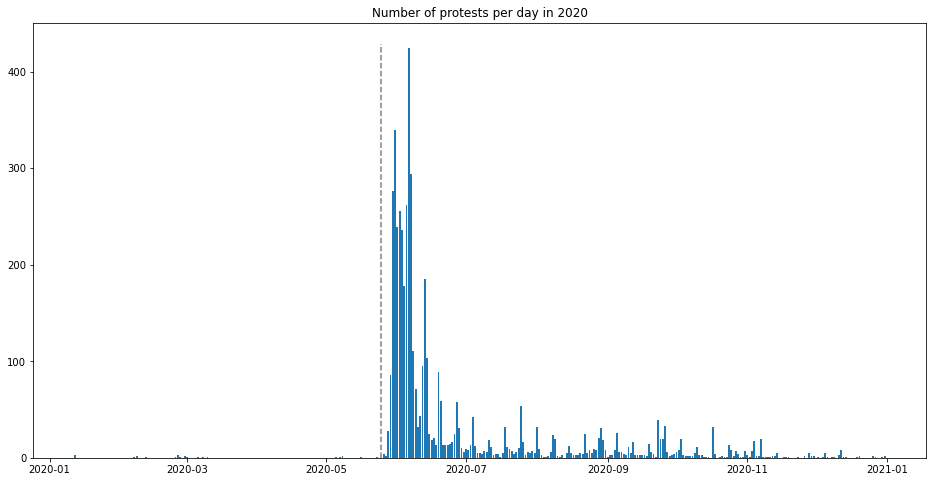

In [26]:
## SAME AS ABOVE - ONE BLOCK PER CHART - BETTER FORMATING 
##### Plot number of protests over time - For FILTERED DATA SET 
# Summarize data to print the numebr of protests reported per day 
fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))


# Total number of protests per day 
ax.bar(data=protests_per_day_filtered, x="date", height="n_protests")
ax.vlines(x=datetime(2020, 5, 25), 
          ymin=0, 
          ymax=protests_per_day_filtered["n_protests"].max() + 5, 
          color="grey", 
          linestyle="dashed"
         )
ax.set_title("Number of protests per day in 2020")

### Number of protests per month 

Text(0.5, 1.0, 'Number of protests per month in 2020')

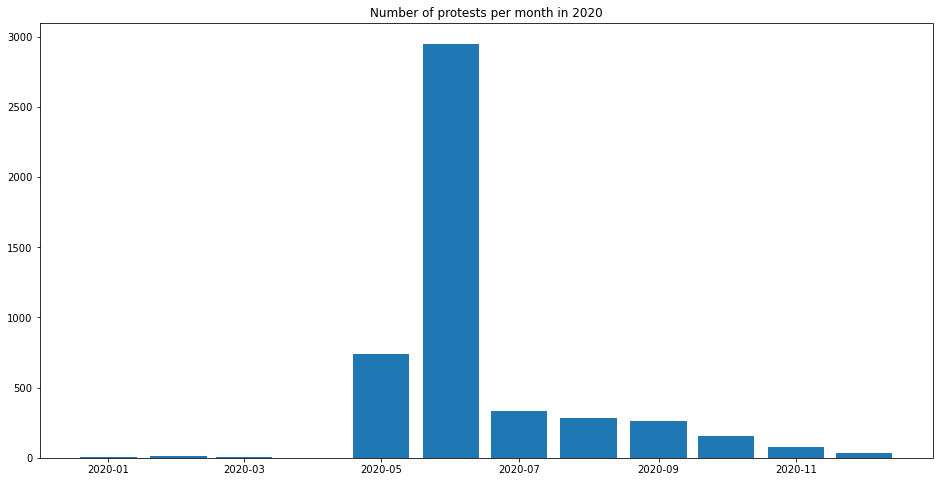

In [27]:
## SAME AS ABOVE - ONE BLOCK PER CHART - BETTER FORMATING 
##### Plot number of protests over time - For FILTERED DATA SET 
# Summarize data to print the numebr of protests reported per day 
fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

# # Total number of protests per month 
ax.bar(data=protests_per_month_filtered, 
       x="month_year", 
       height="n_protests", 
       width = 25
      )

ax.set_title("Number of protests per month in 2020")


## Number of protests per state 

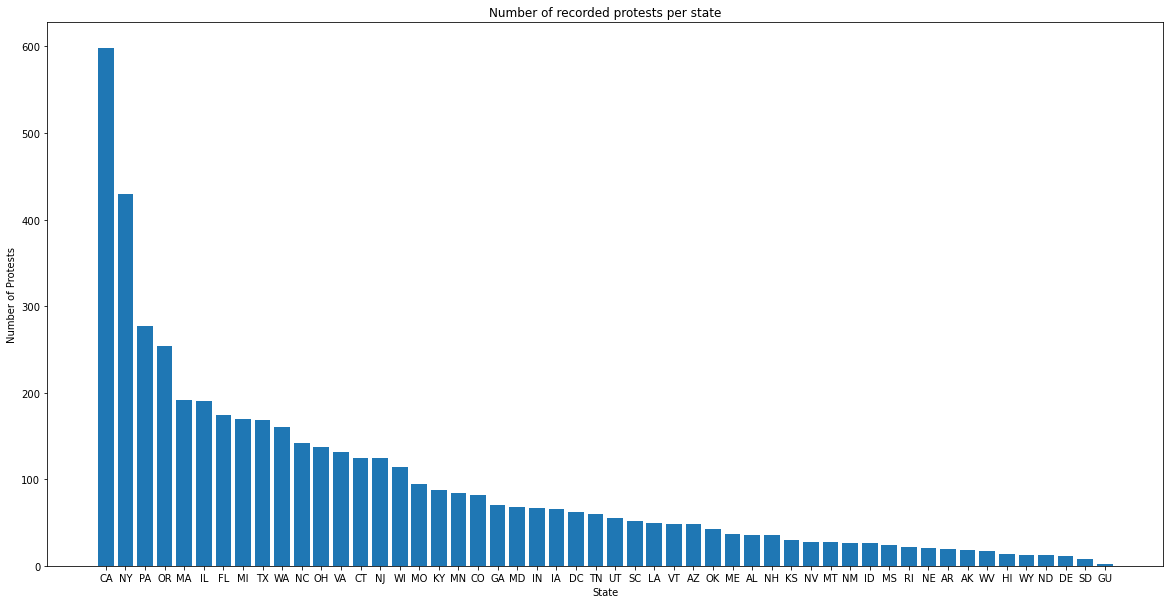

In [28]:
# Which states have the most protests (frequency)? 

# Count the number of records for each state, 
protests_per_state = df.groupby(["state"]).size().sort_values(ascending = False).reset_index(name = 'n_protests')

# Plot the number of records for each state... 
fig, ax = plt.subplots(1, 1, figsize=(20,10))

plt.bar(x = protests_per_state["state"], height = protests_per_state["n_protests"])
plt.title("Number of recorded protests per state")
plt.xlabel("State")
plt.ylabel("Number of Protests")
plt.show()


In [29]:
print(protests_per_state.size)
protests_per_state.head(10)

104


,state,n_protests
0,CA,598
1,NY,430
2,PA,277
3,OR,254
4,MA,192
5,IL,190
6,FL,174
7,MI,169
8,TX,168
9,WA,160


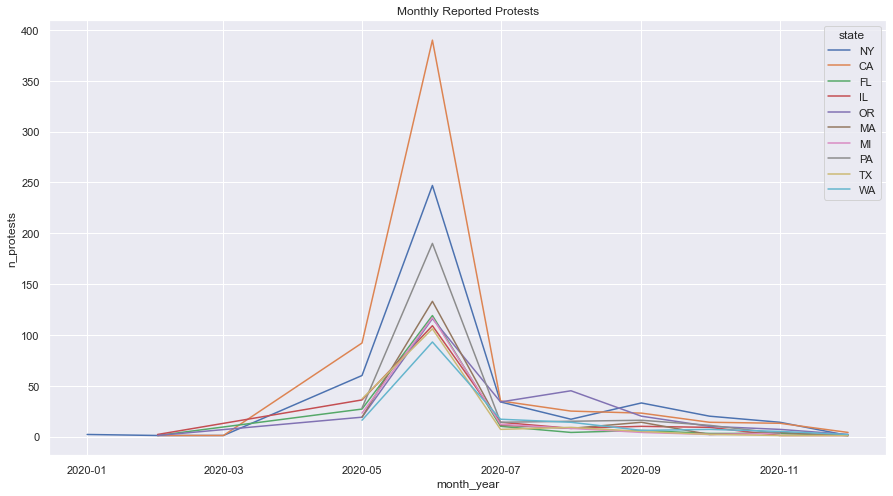

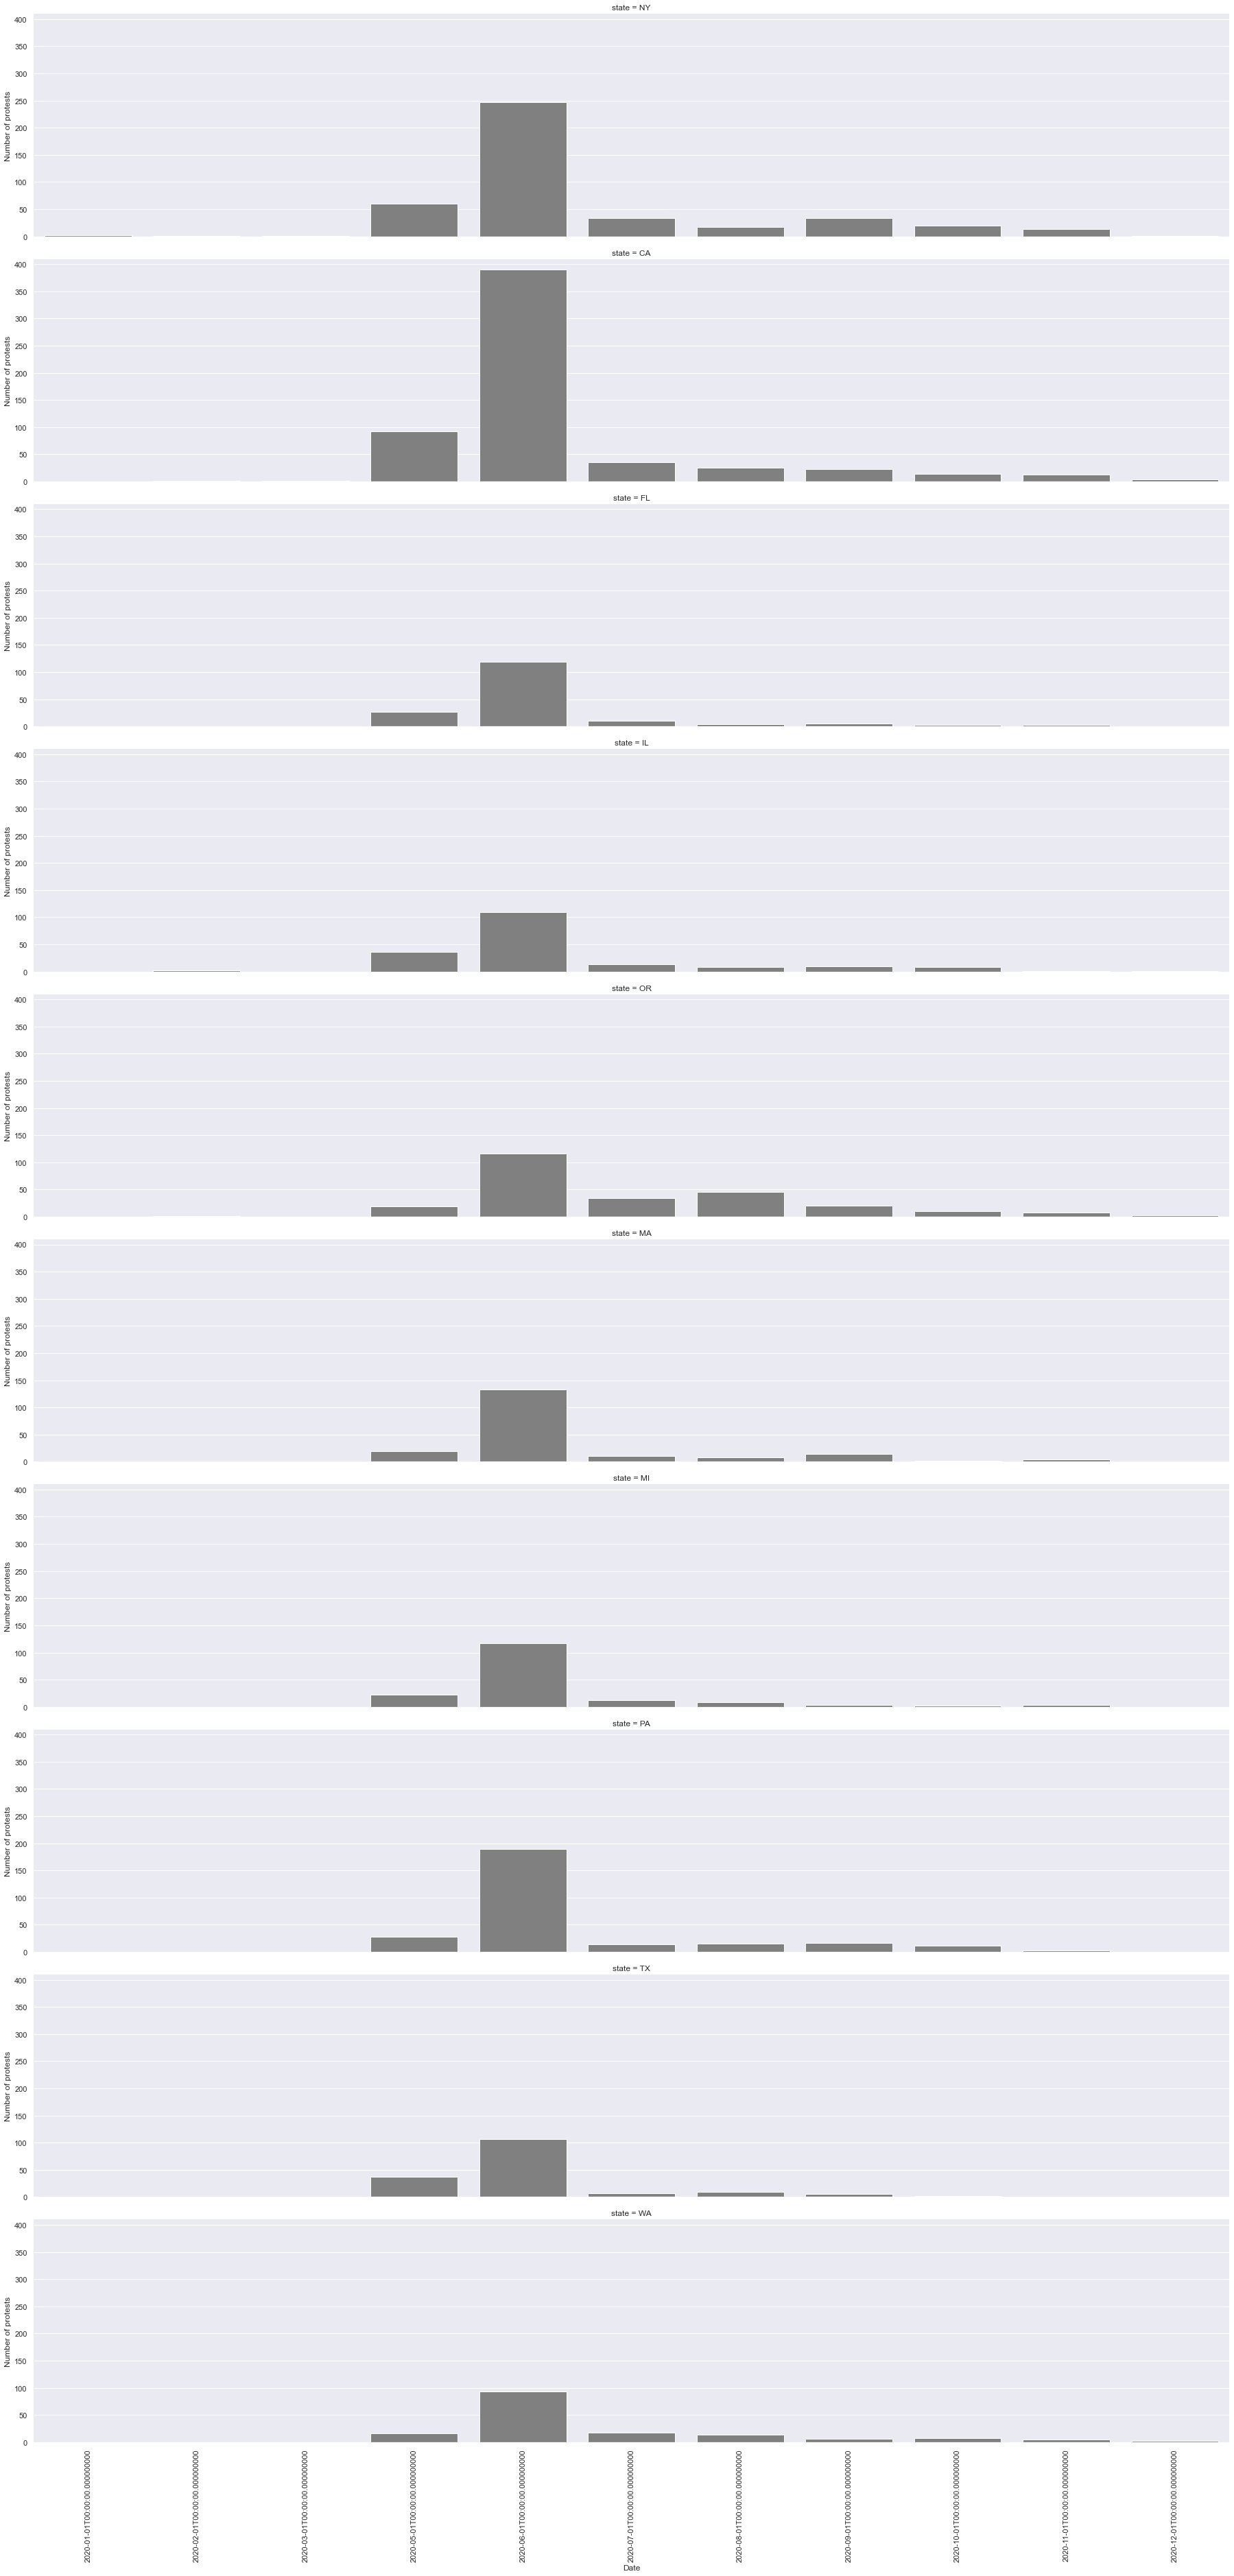

In [30]:
# NUMBER OF PROTESTS PER MONTH - TOP 5 STATES 
# Looking at the top 10 states where protests occured, how are they distributed over time? 
# MONTHLY 

# Get dataframe of protests in top 5 states only - with 3 cols: state, date, n_protests 
top_five_states_protest_frequency_list = ["CA", "NY", "PA", "OR", "MA", "IL", "FL", "MI", "TX", "WA"]
top_five_states_protest_frequency_df = df[df["state"].isin(top_five_states_protest_frequency_list)].groupby(["month_year", "state"]).size().reset_index(name = 'n_protests')


sns.set(rc = {'figure.figsize':(15,8)})
h = sns.lineplot(data=top_five_states_protest_frequency_df, x="month_year", y="n_protests", hue="state")
h.set_title("Monthly Reported Protests")

# Create the plot 
g = sns.catplot(x="month_year", y="n_protests", row="state", 
            data=top_five_states_protest_frequency_df, 
            kind="bar", height=5, aspect=5, color="grey")


# Format and show plot 
(g.set_axis_labels("Date", "Number of protests")
  .set_xticklabels(rotation = 90)
  .despine(left=True)) 


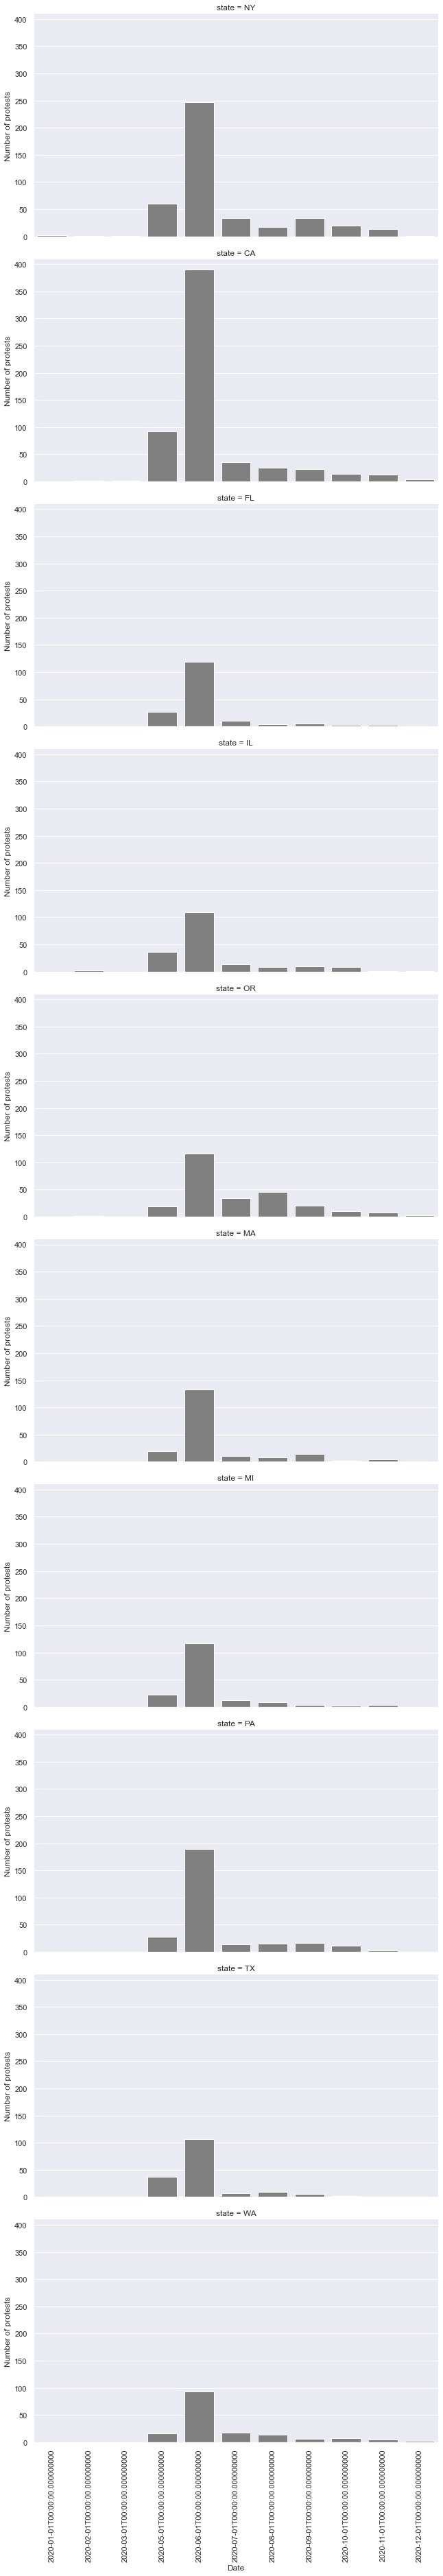

In [31]:
# NUMBER OF PROTESTS PER MONTH - TOP 5 STATES 
# Looking at the top 5 states where protests occured, how are they distributed over time?
# BY MONTH 

# Get dataframe of protests in top 5 states only - with 3 cols: state, date, n_protests 
top_five_states_protest_frequency_df_my = df[df["state"].isin(top_five_states_protest_frequency_list)].groupby(["month_year", "state"]).size().reset_index(name = 'n_protests')

# # View df 
# top_five_states_protest_frequency_df.head()

# Create the plot 
g = sns.catplot(x="month_year", y="n_protests", row="state", 
            data=top_five_states_protest_frequency_df_my, 
            kind="bar", height=5, aspect=2, color="grey")


# Format and show plot 
(g.set_axis_labels("Date", "Number of protests")
 .set_xticklabels(rotation = 90)
#  .set_titles("{row_var}")
#  .despine(left=True)
 ) 


## Number of protests per county 

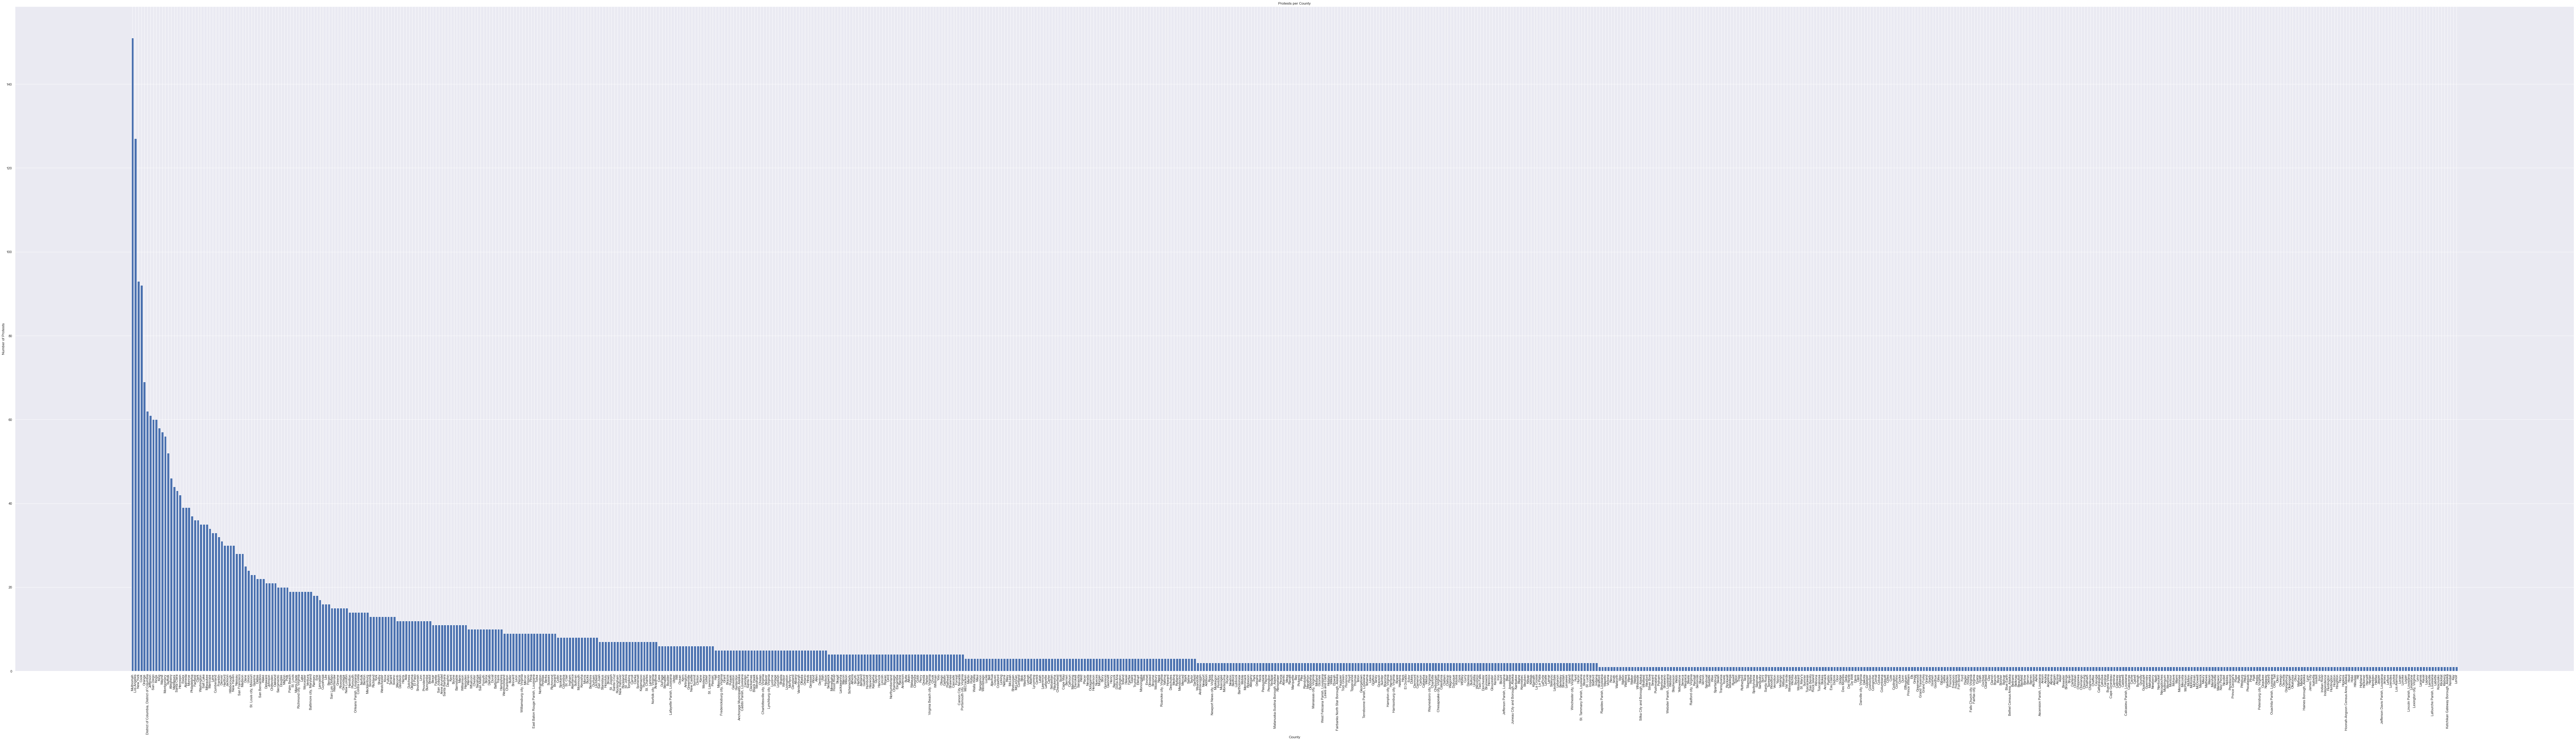

In [32]:
# Which counties have the most protests (frequency)? 

# Count the number of records for each county, 
protests_per_county = df.groupby(["county_y"]).size().sort_values(ascending = False).reset_index(name = 'n_protests')

# Plot the number of records for each county... 
fig, ax = plt.subplots(1, 1, figsize=(150,40))

plt.bar(x = protests_per_county["county_y"], height = protests_per_county["n_protests"])
plt.title("Protests per County")
plt.xlabel("County")
plt.ylabel("Number of Protests")
plt.xticks(rotation = 90)
plt.show()



In [33]:
protests_per_county.head()

,county_y,n_protests
0,Multnomah,151
1,Los Angeles,127
2,New York,93
3,Cook,92
4,Orange,69


                                      county_y  n_protests
0                                    Multnomah         151
1                                  Los Angeles         127
2                                     New York          93
3                                         Cook          92
4                                       Orange          69
5   District of Columbia, District of Columbia          62
6                                    Jefferson          61
7                                    San Diego          60
8                                        Kings          60
9                                         King          58
10                                       Wayne          57
11                                  Montgomery          56
12                                     Suffolk          52
13                                   Allegheny          46
14                                   Middlesex          44
15                                 Santa Clara          

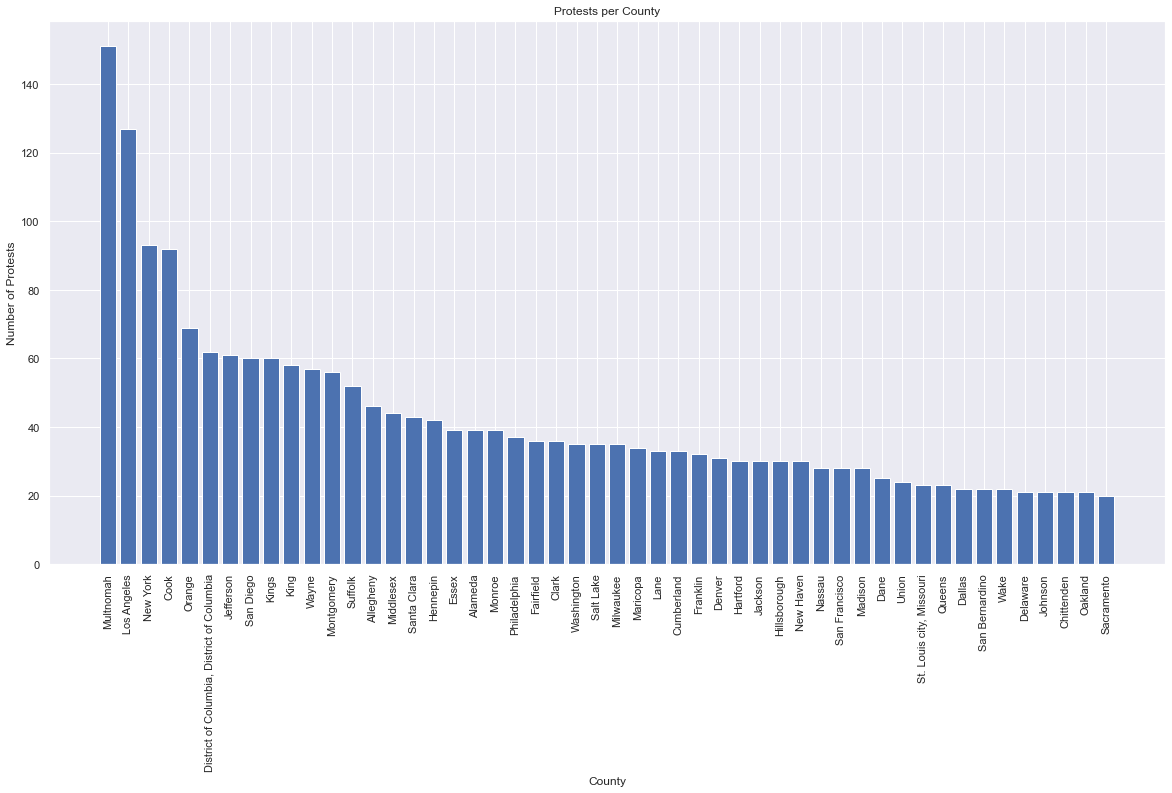

In [34]:
##### Same as plot above, but only for the top 50 counties 

print(protests_per_county.head(20))

fig, ax = plt.subplots(1, 1, figsize=(20,10))

plt.bar(x = protests_per_county["county_y"].iloc[0:50], 
        height = protests_per_county["n_protests"].iloc[0:50])

plt.title("Protests per County")
plt.xlabel("County")
plt.ylabel("Number of Protests")
plt.xticks(rotation = 90)
plt.show()

In [35]:
print(protests_per_county.size)
protests_per_county.head(10)

1564


,county_y,n_protests
0,Multnomah,151
1,Los Angeles,127
2,New York,93
3,Cook,92
4,Orange,69
5,"District of Columbia, District of Columbia",62
6,Jefferson,61
7,San Diego,60
8,Kings,60
9,King,58


# Protest size 

## Total protests turnout per day

Text(0.5, 1.0, 'Total protests turnout per day')

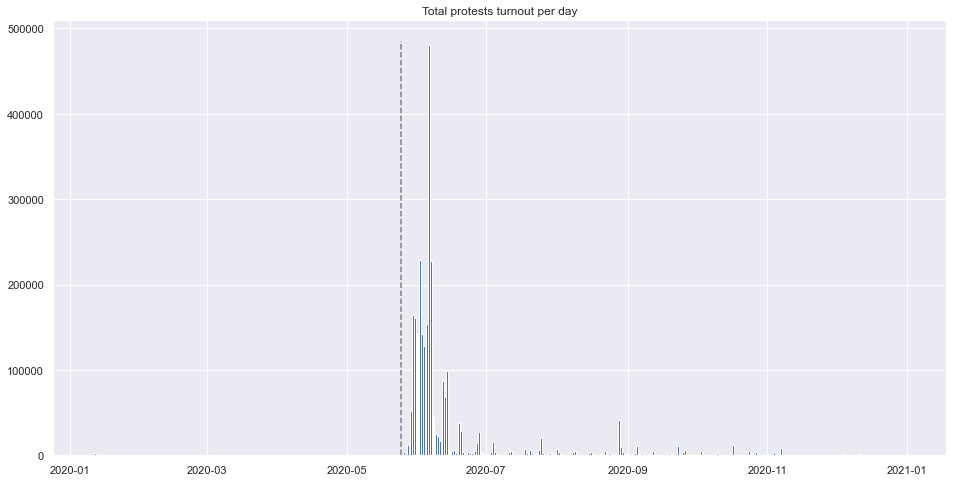

In [36]:
## SAME AS ABOVE - ONE BLOCK PER CHART - BETTER FORMATING 
##### Plot number of protests over time 
# Summarize data to print the numebr of protests reported per day 
fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

# Total number of protests per month 
ax.bar(data=protests_turnout_per_day_filtered, x="date", height="size_mean")

ax.vlines(x=datetime(2020, 5, 25), 
          ymin=0, 
          ymax=protests_turnout_per_day_filtered["size_mean"].max() + 5000, 
          color="grey", 
          linestyle="dashed"
         )

ax.set_title("Total protests turnout per day")



## Total protests turnout per month

Text(0.5, 1.0, 'Total protests turnout per month')

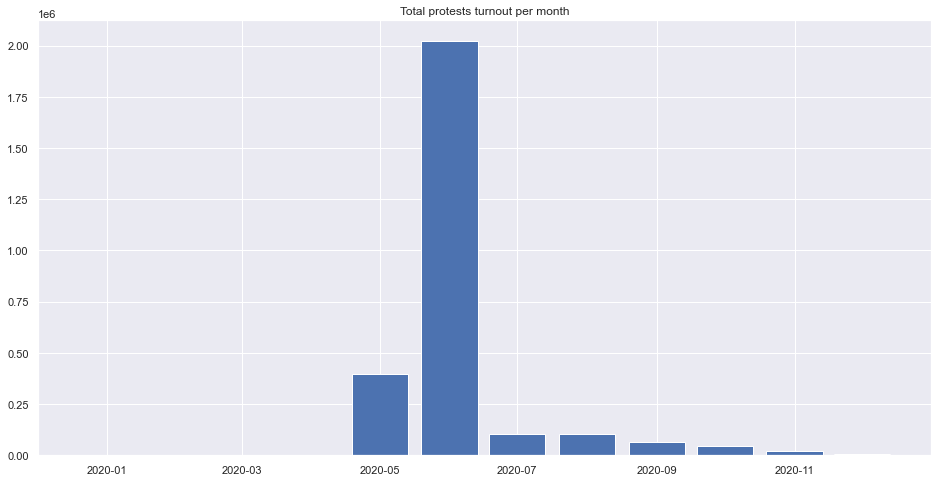

In [37]:
## SAME AS ABOVE - ONE BLOCK PER CHART - BETTER FORMATING 
##### Plot number of protests over time 
# Summarize data to print the numebr of protests reported per day 
fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))


# # Total number of protests per month 
ax.bar(data=protests_turnout_per_month_filtered,
       x=protests_turnout_per_month_filtered["month_year"], 
       height=protests_turnout_per_month_filtered["size_mean"], 
       width=25
      )

ax.set_title("Total protests turnout per month")


## Size by state and county - identifying largets protests

In [38]:
# Plot protester turnout over time, per county 

# Table, grouped by locality, state, sorted by event size 
organized_df = df.sort_values(["state", "county_y", "date", "size_mean"])
# organized_df.head()


# Table, organized by the size of protest first, then county 
df.sort_values(["size_mean", "county_y"], ascending=False).head(20)

# Top 10 largets protests - raw size value [Note, valence = 1.0 for all]
ten_largets_county_protests = df.sort_values(["size_mean", "county_y"], ascending=False).iloc[0:10]
# ten_largets_county_protests.head(20)

# Top 10 largets protests - raw size value [Note, valence = 1.0 for all]
ten_largets_state_protests_population_adjusted = df.sort_values(["size_mean_over_state_pop", "county_y"], ascending=False).iloc[0:10]
# ten_largets_state_protests_population_adjusted.head(20)

# Top 10 largest protests, adjusted for county population 
ten_largets_county_protests_population_adjusted = df.sort_values(["size_mean_over_pop", "county_y"], ascending=False).iloc[0:9]
# ten_largets_county_protests_population_adjusted.head(20)

# Top 10 largest protests, by raw size where valence = 2.0 
ten_largets_county_protests_red =  df[df["valence"] == 2.0].sort_values(["size_mean", "county_y"], ascending=False).iloc[0:9]
# ten_largets_county_protests_red.head(10)

# Top 10 largest protests, size adjusted for county population, where valence = 2.0 
ten_largets_county_protests_red =  df[df["valence"] == 2.0].sort_values(["size_mean_over_pop", "county_y"], ascending=False).iloc[0:9]
# ten_largets_county_protests_red.head(10)


In [39]:
# Print top 10 largest protests (largest overal)
ten_largets_county_protests[["date", "state", "county_y", "size_mean"]].head(20) 

,date,state,county_y,size_mean
2021,2020-06-06,DC,"District of Columbia, District of Columbia",110000.0
2996,2020-06-12,WA,King,60000.0
1226,2020-06-02,TX,Harris,60000.0
2276,2020-06-06,PA,Philadelphia,44000.0
4252,2020-08-28,DC,"District of Columbia, District of Columbia",35000.0
2375,2020-06-07,CA,Los Angeles,30000.0
3190,2020-06-14,CA,Los Angeles,25000.0
2067,2020-06-06,IL,Cook,25000.0
3685,2020-06-28,NY,New York,20000.0
1646,2020-06-04,TN,Davidson,20000.0


In [40]:
# Print top 10 largest protests per capita (county)
ten_largets_county_protests_population_adjusted[["date", "state", "county_y", "size_mean", "size_mean_over_pop"]].head(20) 

,date,state,county_y,size_mean,size_mean_over_pop
2021,2020-06-06,DC,"District of Columbia, District of Columbia",110000.0,0.159525
1652,2020-06-04,VA,"Falls Church city, Virginia",2000.0,0.136444
1801,2020-06-05,ME,Piscataquis,1700.0,0.101190
2625,2020-06-07,VT,Washington,5000.0,0.083602
4169,2020-08-17,MT,Carbon,872.0,0.083262
1255,2020-06-03,AK,"Haines Borough, Alaska",150.0,0.072115
2557,2020-06-07,NY,Rensselaer,11000.0,0.068268
761,2020-06-01,AK,"Hoonah-Angoon Census Area, Alaska",150.0,0.063425
1863,2020-06-05,OK,Pontotoc,2000.0,0.052542


In [41]:
# Print top 10 largest protests per capita (state)
ten_largets_state_protests_population_adjusted[["date", "state", "county_y", "size_mean", "size_mean_over_state_pop"]].head(20) 

,date,state,county_y,size_mean,size_mean_over_state_pop
2021,2020-06-06,DC,"District of Columbia, District of Columbia",110000.0,0.159525
4252,2020-08-28,DC,"District of Columbia, District of Columbia",35000.0,0.050758
1891,2020-06-05,RI,Providence,11000.0,0.010024
2284,2020-06-06,RI,Providence,10000.0,0.009113
2996,2020-06-12,WA,King,60000.0,0.007787
2625,2020-06-07,VT,Washington,5000.0,0.007775
4657,2020-10-17,DC,"District of Columbia, District of Columbia",5100.0,0.007396
2276,2020-06-06,PA,Philadelphia,44000.0,0.003384
1823,2020-06-05,MT,Gallatin,3500.0,0.003228
2517,2020-06-07,NH,Rockingham,4000.0,0.002904


# Relationship between protest size and unemployment 

               rate  size_mean
rate       1.000000   0.043425
size_mean  0.043425   1.000000


[Text(0, 0.5, 'State Population'),
 Text(0.5, 0, 'Number of participants per protest')]

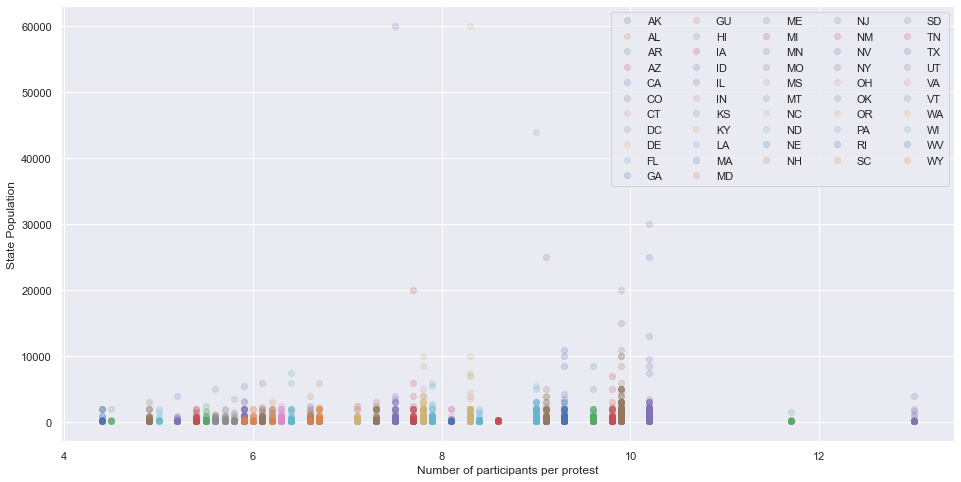

In [62]:
# JOIN THE UNEMPLOYMENT RATE PER STATE 

unemployment_and_size_mean = pd.merge(organized_df[["date", "state", "county_y", "size_mean"]], unemployment_df, on="state", how="left")
unemployment_and_size_mean.head()

unemployment_and_size_mean_for_corr = unemployment_and_size_mean[["rate", "size_mean"]]
print(unemployment_and_size_mean_for_corr.corr(method="pearson"))

fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

groups = unemployment_and_size_mean.groupby("state")
for name, group in groups:
    plt.plot(group["rate"], group["size_mean"], marker="o", linestyle="", label=name, alpha=0.2)
ax.legend(loc="upper right", ncol=5)
ax.set(ylabel="State Population", xlabel="Number of participants per protest")

              rate  size_mean
rate       1.00000    0.06519
size_mean  0.06519    1.00000


[Text(0.5, 0, 'Unemployment rate'),
 Text(0, 0.5, 'Number of participants per protest')]

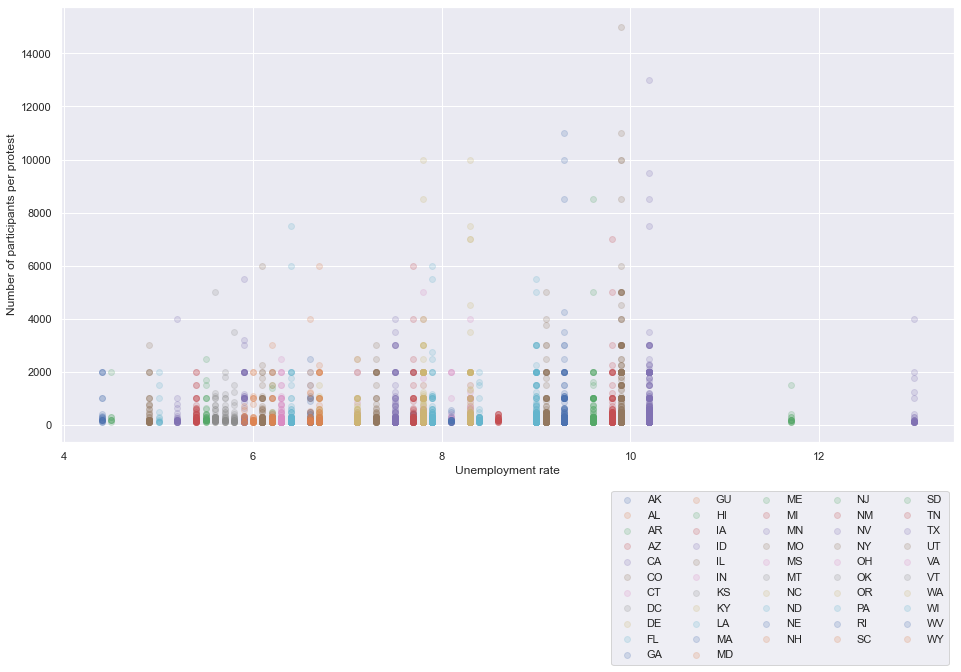

In [63]:
# Zoom in to view majority of records 

unemployment_and_size_mean_zoom = unemployment_and_size_mean[unemployment_and_size_mean["size_mean"] < 20000]

unemployment_and_size_mean_for_corr_zoom = unemployment_and_size_mean_zoom[["rate", "size_mean"]]
print(unemployment_and_size_mean_for_corr_zoom.corr(method="pearson"))

fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

groups = unemployment_and_size_mean_zoom.groupby("state")
for name, group in groups:
    plt.plot(group["rate"], group["size_mean"], marker="o", linestyle="", label=name, alpha=0.2)
ax.legend(bbox_to_anchor=(1, -0.1), ncol=5)
ax.set(xlabel="Unemployment rate", ylabel="Number of participants per protest")

# Relationship between protest frequncy and unemployment 

  state  n_protests     state_name  rate
0    CA         598     California  10.2
1    NY         430       New York   9.9
2    PA         277   Pennsylvania   9.0
3    OR         254         Oregon   7.8
4    MA         192  Massachusetts   9.3
                rate  n_protests
rate        1.000000    0.413076
n_protests  0.413076    1.000000


[Text(0.5, 0, 'Unemployment rate'), Text(0, 0.5, 'Number of protests')]

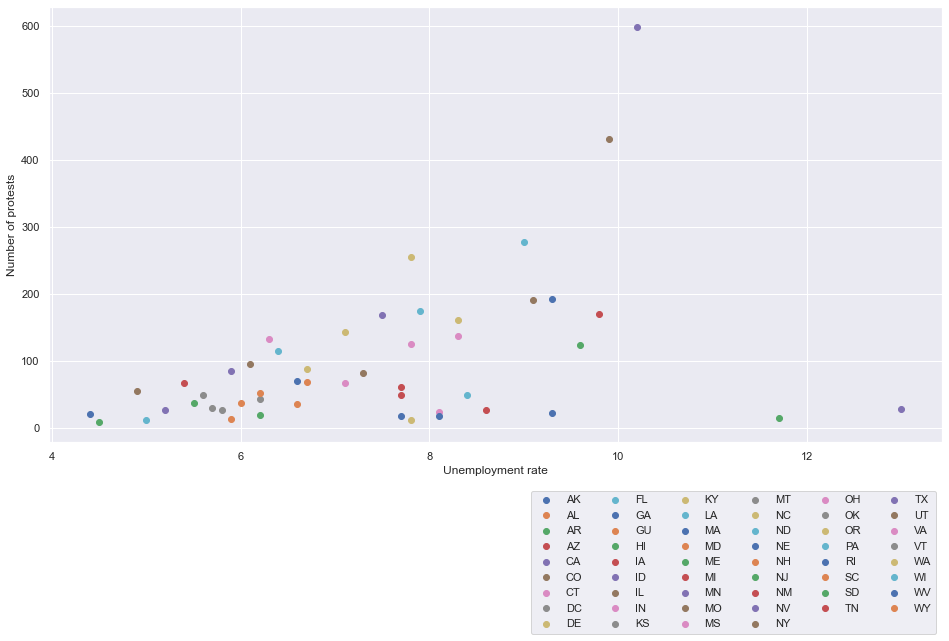

In [65]:
# Join unemployment data 
protests_per_state_unemployment = pd.merge(protests_per_state, unemployment_df, on="state", how="left") 
print(protests_per_state_unemployment.head())

protests_per_state_unemployment_for_corr = protests_per_state_unemployment[["rate", "n_protests"]]
print(protests_per_state_unemployment_for_corr.corr(method="pearson"))

fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

groups = protests_per_state_unemployment.groupby("state")
for name, group in groups:
    plt.plot(group["rate"], group["n_protests"], marker="o", linestyle="", label=name)
ax.legend(bbox_to_anchor=(1, -0.1), ncol=6)
ax.set(xlabel="Unemployment rate", ylabel="Number of protests")



# Relationship between protest size and population 

                  size_mean  state_population
size_mean          1.000000          0.029392
state_population   0.029392          1.000000


[Text(0.5, 0, 'State Population'),
 Text(0, 0.5, 'Number of participants per protest')]

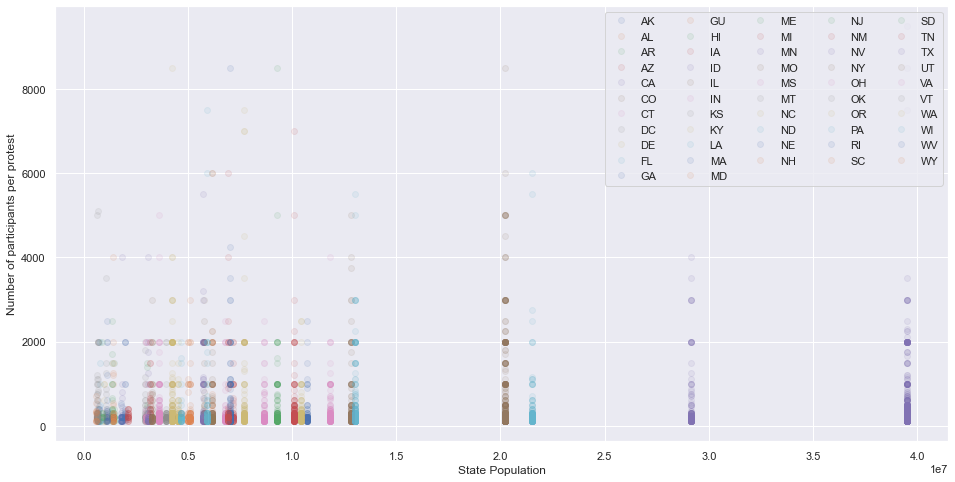

In [67]:
### Scatter plot - size of protest vs state population 

dt_for_size_state_pop_scatter = df[["size_mean", "state", "state_population"]]
dt_for_size_state_pop_scatter = dt_for_size_state_pop_scatter[dt_for_size_state_pop_scatter["size_mean"] < 10000]
dt_for_size_state_pop_scatter.head()

dt_for_size_state_pop_scatter_for_corr = dt_for_size_state_pop_scatter[["size_mean", "state_population"]]
print(dt_for_size_state_pop_scatter_for_corr.corr(method="pearson"))


fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

groups = dt_for_size_state_pop_scatter.groupby("state")
for name, group in groups:
    plt.plot(group["state_population"], group["size_mean"], marker="o", linestyle="", label=name, alpha=0.1)
ax.legend(loc="upper right", ncol=5)
ax.set(xlabel="State Population", ylabel="Number of participants per protest")


                          size_mean_over_state_pop  state_population
size_mean_over_state_pop                  1.000000         -0.258162
state_population                         -0.258162          1.000000


Text(0.5, 1.0, 'State population by adjusted protestor turnout')

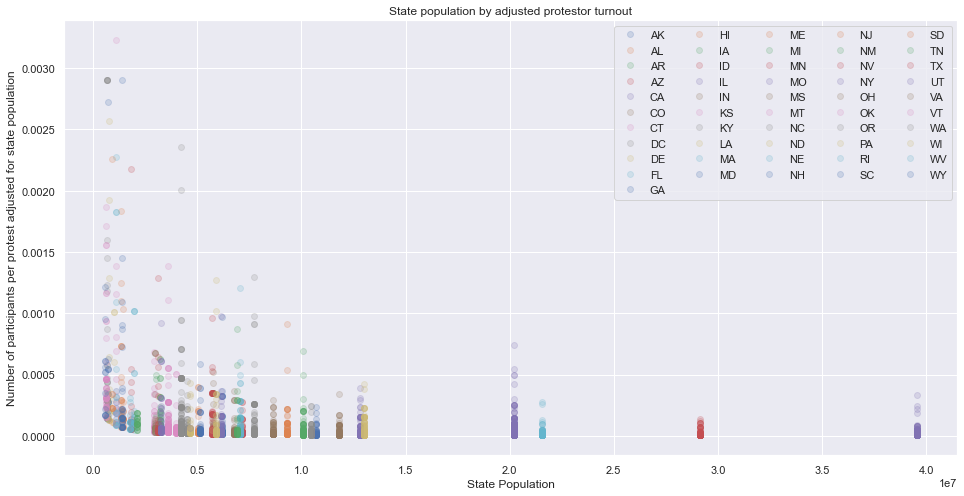

In [68]:
### Scatter plot - size or protest vs state population
### Adjusted for the population 

dt_for_size_state_pop_scatter = df[["size_mean", "state", "size_mean_over_state_pop", "state_population"]]
dt_for_size_state_pop_scatter = dt_for_size_state_pop_scatter[dt_for_size_state_pop_scatter["size_mean_over_state_pop"] < 0.004]
dt_for_size_state_pop_scatter = dt_for_size_state_pop_scatter[dt_for_size_state_pop_scatter["size_mean"] < 20000]
dt_for_size_state_pop_scatter.head()

dt_for_size_state_pop_scatter_for_corr = dt_for_size_state_pop_scatter[["size_mean_over_state_pop", "state_population"]]
print(dt_for_size_state_pop_scatter_for_corr.corr(method="pearson"))

fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

groups = dt_for_size_state_pop_scatter.groupby("state")
for name, group in groups:
    plt.plot(group["state_population"], group["size_mean_over_state_pop"], marker="o", linestyle="", label=name, alpha=0.2)
ax.legend(loc="upper right", ncol=5)
ax.set(xlabel="State Population", ylabel="Number of participants per protest adjusted for state population")
ax.set_title("State population by adjusted protestor turnout")


                    size_mean_over_pop  population
size_mean_over_pop            1.000000   -0.234112
population                   -0.234112    1.000000


Text(0.5, 1.0, 'County population by participants per protest (adjusted for county population)')

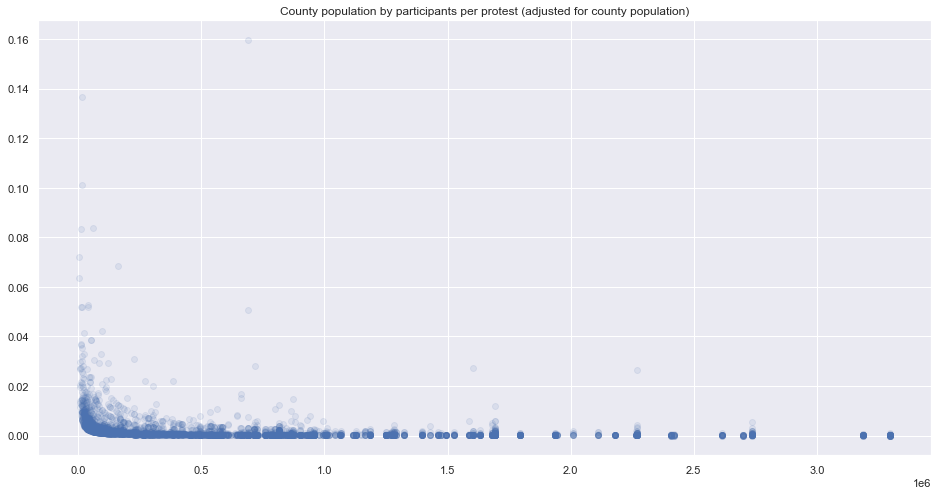

In [69]:
### Scatter plot - size or protest vs state population 

dt_for_size_county_pop_scatter = df[["size_mean", "state", "size_mean_over_pop", "population"]]
# dt_for_size_county_pop_scatter = dt_for_size_state_pop_scatter[dt_for_size_state_pop_scatter["size_mean_over_state_pop"] < 0.004]
dt_for_size_county_pop_scatter = dt_for_size_county_pop_scatter[dt_for_size_county_pop_scatter["population"] < 4000000]
dt_for_size_county_pop_scatter.head()

dt_for_size_county_pop_scatter_for_corr = dt_for_size_county_pop_scatter[["size_mean_over_pop", "population"]]
print(dt_for_size_county_pop_scatter_for_corr.corr(method="pearson"))

fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))


# Total number of protests per month 
ax.scatter(data=dt_for_size_county_pop_scatter,
           y="size_mean_over_pop", 
           x="population", 
          alpha=0.1)

ax.set_title("County population by participants per protest (adjusted for county population)")

# Relationship between protest frequency and population 

### By State Population 

                  state_population  n_protests
state_population          1.000000    0.837152
n_protests                0.837152    1.000000


[Text(0.5, 0, 'State Population'), Text(0, 0.5, 'Number of protests')]

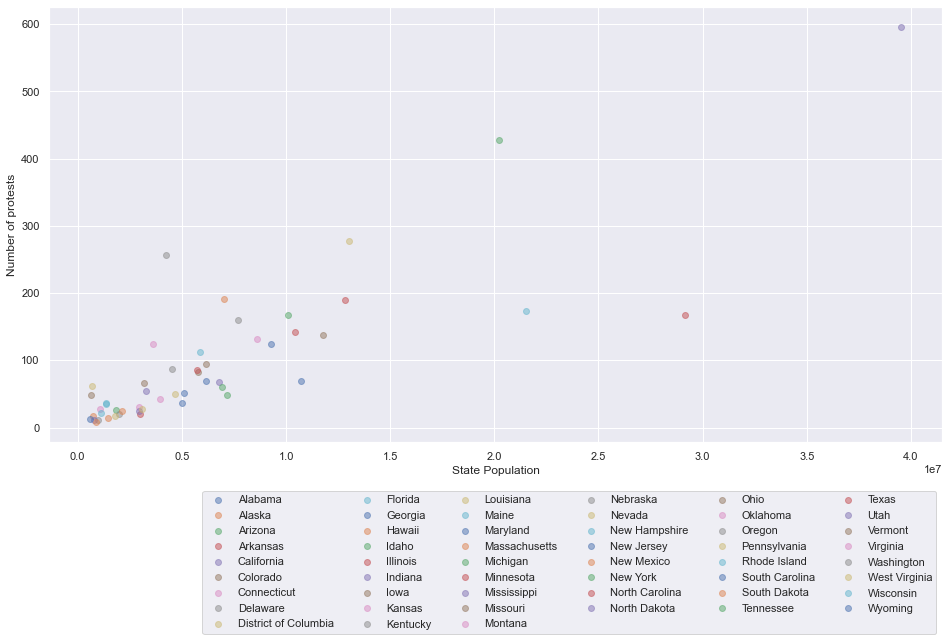

In [70]:
# STATE 

# Merge state population with above dfs 
protests_per_state_pop = df.groupby(["state_name"]).size().reset_index(name="n_protests")
protests_per_state_pop_with_pop = pd.merge(protests_per_state_pop, state_pop_df, on="state_name", how="left")
protests_per_state_pop_with_pop.head(100)

protests_per_state_pop_with_pop_for_corr = protests_per_state_pop_with_pop[["state_population", "n_protests"]]
print(protests_per_state_pop_with_pop_for_corr.corr(method="pearson"))

fig, ax = plt.subplots(1,1, sharex = True, figsize=(16,8))

groups = protests_per_state_pop_with_pop.groupby("state_name")
for name, group in groups:
    plt.plot(group["state_population"], group["n_protests"], marker="o", linestyle="", label=name, alpha=0.5)
ax.legend(bbox_to_anchor=(1, -0.1), ncol=6)
ax.set(xlabel="State Population", ylabel="Number of protests")


### By County Population 

            population  n_protests
population    1.000000    0.317358
n_protests    0.317358    1.000000
            population  n_protests
population    1.000000    0.105924
n_protests    0.105924    1.000000


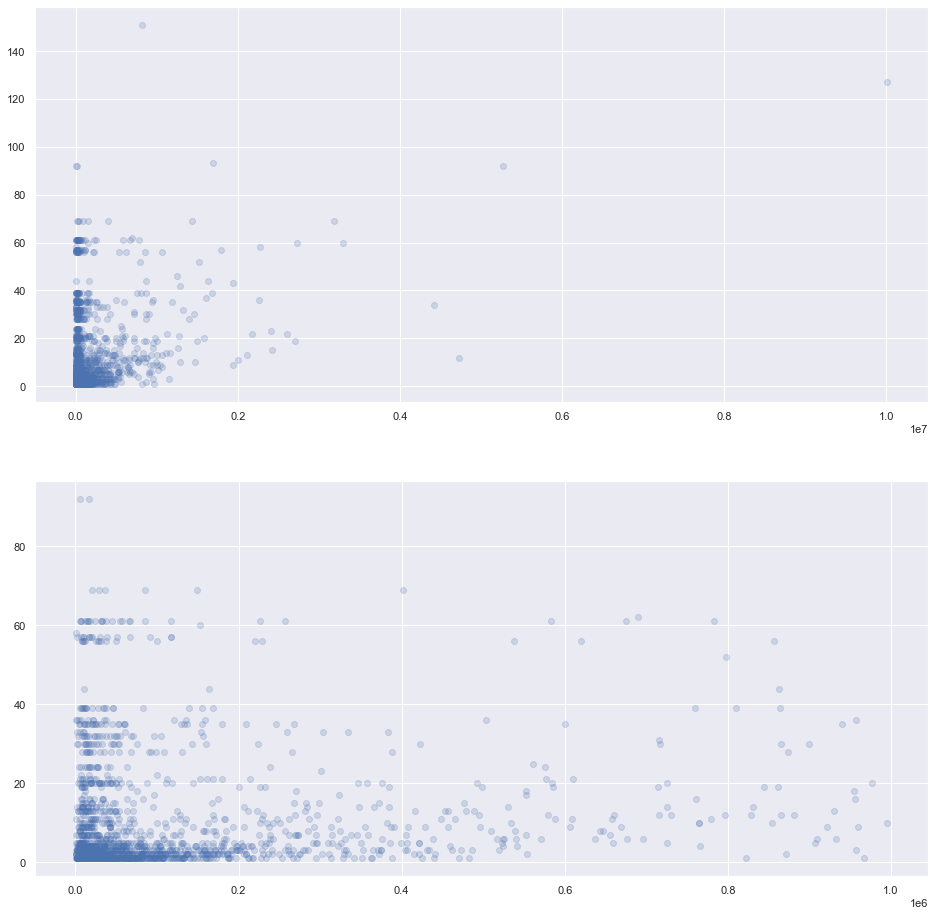

In [73]:
# COUNTY 

county_pop = county_pop_df_filtered
county_pop["county"] = county_pop_df_filtered["county"].str.replace(' County([\s\S]*)$', '', regex=True)
# county_pop.head()

# Group data for desired key column 
protests_per_county_pop = df.groupby(["county_y"]).size().reset_index(name="n_protests")
# Change name for join 
protests_per_county_pop = protests_per_county_pop.rename(columns={'county_y': 'county'})
# Join with county dataframe 
protests_per_county_pop_with_pop = pd.merge(protests_per_county_pop, county_pop, on="county", how="left")
# protests_per_county_pop_with_pop.head(100)
protests_per_county_pop_with_pop_adjusted_for_visual = protests_per_county_pop_with_pop[protests_per_county_pop_with_pop["population"] < 1000000]
protests_per_county_pop_with_pop_adjusted_for_visual = protests_per_county_pop_with_pop_adjusted_for_visual[protests_per_county_pop_with_pop_adjusted_for_visual["n_protests"] < 100]


protests_per_county_pop_with_pop_for_corr = protests_per_county_pop_with_pop[["population", "n_protests"]]
print(protests_per_county_pop_with_pop_for_corr.corr(method="pearson"))

protests_per_county_pop_with_pop_adjusted_for_visual_for_corr = protests_per_county_pop_with_pop_adjusted_for_visual[["population", "n_protests"]]
print(protests_per_county_pop_with_pop_adjusted_for_visual_for_corr.corr(method="pearson"))


fig, ax = plt.subplots(2,1, sharex = False, figsize=(16,16))

# Total number of protests per month 
ax[0].scatter(
    data=protests_per_county_pop_with_pop,
    y="n_protests", 
    x="population", 
    alpha=0.2
)

ax[1].scatter(
    data=protests_per_county_pop_with_pop_adjusted_for_visual,
    y="n_protests", 
    x="population", 
    alpha=0.2
)



# Are protests more likely to occur on weekends?  

In [50]:
def findDay(date):
    born = datetime.strptime(date, '%d %m %Y').weekday()
    return (calendar.day_name[born])
 
# Driver program
protest_date=list(df['date'])
day=[]
Weekday=[]
for i in range(len(protest_date)):
    x=str(protest_date[i])
    dt=''
    date=[x[8:10],' ',x[5:7],' ',x[0:4]]
    dt = dt.join(date)
    dy=findDay(dt)
    if dy=='Sunday' or dy=='Saturday':
        wk='Weekend'
    else:
        wk='Work day'
    Weekday.append(wk)
    day.append(dy)
    
#print(day)
#print(Weekday)
df['Week day']=Weekday
#print(protests_df_filtered1)

Df_day_of_week = df.groupby(['Week day']).size().reset_index()
print(Df_day_of_week)

   Week day     0
0   Weekend  2436
1  Work day  2412


   Week day     0
0   Weekend  2436
1  Work day  2412


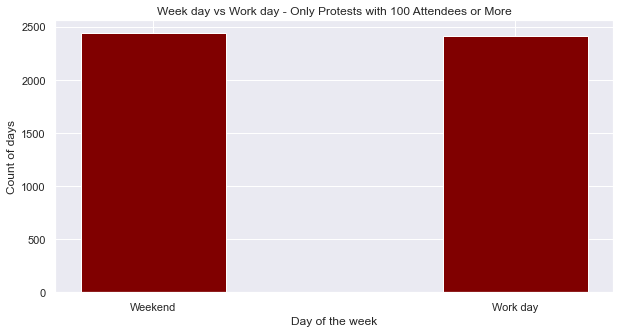

In [51]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Df_day_of_week['Week day'],Df_day_of_week[0] , color ='maroon',
        width = 0.4)
 
plt.xlabel("Day of the week")
plt.ylabel("Count of days")
plt.title("Week day vs Work day - Only Protests with 100 Attendees or More")
print(Df_day_of_week)
plt.show()

In [52]:
adj = Df_day_of_week
adj.at[0,"0"]=2436/53
adj.at[1,"0"]=2411/262
adj
#adj.drop([0],axis=1,inplace=True)

,Week day,0,0
0,Weekend,2436,45.962264
1,Work day,2412,9.202290


   Week day     0          0
0   Weekend  2436  45.962264
1  Work day  2412   9.202290


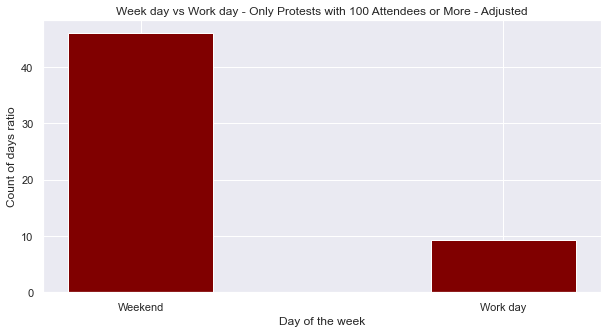

In [53]:
adj

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(adj['Week day'],adj["0"] , color ='maroon',
        width = 0.4)
 
plt.xlabel("Day of the week")
plt.ylabel("Count of days ratio")
plt.title("Week day vs Work day - Only Protests with 100 Attendees or More - Adjusted")
print(adj)
plt.show()

# Making csv files for arcMAP 

In [54]:
#Data for total turnout for protests in 2020 by county.
bystate = df[["state","date","size_mean","population"]].groupby(["state"])

funcdict = {"state":"first","date":"count","size_mean":"sum","population":"sum"}

sdf = bystate.agg(funcdict)

sdf = sdf[(sdf.state != "GU") & (sdf.state != "DC")]

sdf["size_mean"] = sdf["size_mean"].apply(lambda x: int(x))

sdf["population"] = sdf["size_mean"] / sdf["population"]

sdf.rename(columns={"date":"num_protests","size_mean":"sum_daily_protestors","population":"sum_daily_protestors_adjusted"},inplace=True)

sdf.drop(columns=["state"],inplace=True)

unemp = pd.read_csv("data/newest_state_abbrev.csv")

unemp.rename(columns={"state":"name","state_abbrev":"state","rate":"rate"},inplace=True)

sdf_corr = pd.merge(sdf,unemp,on="state",how="left")

sdf_corr.corr(method="pearson")

,num_protests,sum_daily_protestors,sum_daily_protestors_adjusted,rate
num_protests,1.000000,0.953266,-0.410871,0.413076
sum_daily_protestors,0.953266,1.000000,-0.335938,0.414457
sum_daily_protestors_adjusted,-0.410871,-0.335938,1.000000,-0.390873
rate,0.413076,0.414457,-0.390873,1.000000


In [55]:
#Data for total turnout for protests in 2020 by county.
by_county = df[["geoid","location","state","size_mean","population"]].groupby(["geoid"])

func_dict = {"location":"first","state":"first","size_mean":"sum","population":"first"}

total_bodies = by_county.agg(func_dict)

total_bodies["size_mean"] = total_bodies["size_mean"].apply(lambda x: int(x))

total_bodies["population"] = total_bodies["size_mean"] / total_bodies["population"]

total_bodies.rename(columns={"size_mean":"sum_daily_protestors","population":"sum_daily_protestors_adjusted"},inplace=True)

total_bodies[["location","sum_daily_protestors_adjusted"]].sort_values("sum_daily_protestors_adjusted",ascending=False).head(5)

,location,sum_daily_protestors_adjusted
geoid,,
11001,"Washington, DC",0.252031
51610,"Falls Church, VA",0.136444
51830,"Williamsburg, VA",0.129660
41051,"Portland, OR",0.122711
50023,"Montpelier, VT",0.104319


In [56]:
total_bodies.sort_values("sum_daily_protestors",ascending=False).head(30)

,location,state,sum_daily_protestors,sum_daily_protestors_adjusted
geoid,,,,
11001,"Washington, DC",DC,173787,0.252031
36061,"New York, NY",NY,139220,0.082172
06037,"Los Angeles, CA",CA,124473,0.012430
53033,"Seattle, WA",WA,124060,0.054660
41051,"Portland, OR",OR,100062,0.122711
36047,"New York, NY",NY,96975,0.035443
17031,"Oak Park, IL",IL,83256,0.015782
48201,"Houston, TX",TX,65750,0.013897
42101,"Philadelphia, PA",PA,64901,0.040467
